# Model-selection for KRR and RR
Let's look at a 3-D example

In [4]:
# Importing the necessary packages 
import numpy as np

from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
from sklearn.gaussian_process.kernels import RBF

from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge

### Let's create some toy data

In [8]:
# Defining the functions for creating the data
def underlying(x, y):
    # Gives f(x)
    return (-(x * y)**4 + 2 * x**2 + np.exp(-np.pi * y**2) 
            + np.sin(15 * y)/5)


def create_data(n=500):
    # Randomly samples x and then
    # gives y = f(x) + e
    
    # The shape of X is different than in lecture, because of sklearn
    X = np.random.uniform(low=-1, high=1, size=(n, 2)) 
    y = underlying(*X.T) + np.random.normal(loc=0, scale=2E-1, size=n)
    return X, y

In [6]:
# Let's look at what we created
def plot_data(X, y, predictor=None, grid_size=50, ax=None, legend=True):

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    
    # Greate grid for plotting meshgrid
    grid = np.linspace(-1, 1, grid_size)
    X_grid, Y_grid = np.meshgrid(grid, grid)
    Z_grid = underlying(X_grid, Y_grid)
    ax.plot_wireframe(X_grid, Y_grid, Z_grid, alpha=.1, color='black', label='underlying')
    
    ax.scatter(*X.T, y, color='red', label='train data')
    
    # Maybe this will come in handy later
    if predictor:
        grid_prediction = predictor.predict(np.vstack([X_grid.flatten(), Y_grid.flatten()]).T)
        ax.plot_wireframe(X_grid, Y_grid, 
                          grid_prediction.reshape(X_grid.shape)
                          , alpha=.2, color='blue', label='predicted')
        if legend:
            ax.legend()
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')
    ax.set_zlabel('$Y(X)$')

    plt.show()

In [7]:
n = 80
X, y = create_data(n=n)

%matplotlib qt
#%matplotlib inline
plot_data(X, y)

## Let's apply some models

In [14]:
# Useful helper functions
def mse(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

def score_mse(model, X, y):
    return mse(y, model.predict(X))

def train_predict_score(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    return score_mse(model, X_test, y_test), score_mse(model, X_train, y_train)

## Cross Validation

In [8]:
# Let's see what sklearn KFold does
from sklearn.model_selection import KFold

k = 3
test = range(3)
kf_test = KFold(k)
for train_index, test_index in kf_test.split(test):
    print(f'train: {train_index}, test: {test_index}')


train: [1 2], test: [0]
train: [0 2], test: [1]
train: [0 1], test: [2]


In [9]:
def cross_validation(model, X, y, k=10):
    mse_test = 0
    mse_train = 0
    kf = KFold(k)
    for train_indices, test_indices in kf.split(X):
        c_test, c_train = train_predict_score(model, 
                                              X[train_indices,:], 
                                              y[train_indices],
                                              X[test_indices,:], 
                                              y[test_indices])
        mse_test += c_test
        mse_train += c_train
    return mse_test/k, mse_train/k

## Let's try to find the optimal Parameters for RR with Grid Search

Since we only have one parameter, it's quite simple

In [12]:
np.geomspace(0.1, 10, 5)

array([ 0.1       ,  0.31622777,  1.        ,  3.16227766, 10.        ])

In [15]:
from sklearn.linear_model import Ridge

# Logarithmic scale
lambdas = np.geomspace(1E-4, 1E10, 100)

mse_test = []
mse_train = []

for lam in lambdas:
    model = Ridge(alpha=lam)
    c_mse_test, c_mse_train = cross_validation(model, X,y)
    mse_test.append(c_mse_test)
    mse_train.append(c_mse_train)

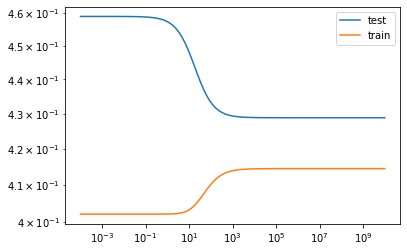

In [16]:
%matplotlib inline 
plt.plot(lambdas, mse_test, label='test')
plt.plot(lambdas, mse_train, label='train')
plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.show()

In [17]:
print(f'The optimal lambda is {lambdas[np.argmin(mse_test)]:.1E}'
      f' with test-mse {np.min(mse_test):.3f}')

The optimal lambda is 1.0E+10 with test-mse 0.429


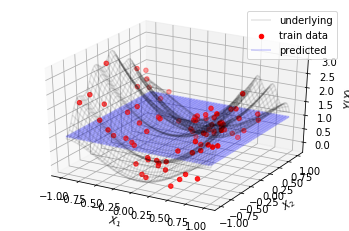

In [18]:
optimal_rr = Ridge(alpha=lambdas[np.argmin(mse_test)])
optimal_rr.fit(X, y)
plot_data(X, y, optimal_rr)

## Kernel Ridge Regression
Here we have 2 Hyperparameters regularization strength $\lambda$ and lengthscale $\sigma$

In [20]:
#Let's look at possible Hyperparameters
%matplotlib qt 
X_new, y_new = create_data(20)

fig = plt.figure()
params = {'1': {'lambda':.1, 'sigma': .1},
          '2': {'lambda':10, 'sigma': .1},
          '3': {'lambda':.1, 'sigma': .5},
          '4': {'lambda':10, 'sigma': .5},
          }
for key in params:
    ax = fig.add_subplot(2, 2, int(key), projection='3d')
    krr = KernelRidge(alpha=params[key]['lambda'], 
                      kernel=RBF(length_scale=params[key]['sigma']))
    krr.fit(X_new, y_new)
    plot_data(X_new, y_new, krr, grid_size=100, ax=ax, legend=False)
    ax.set_title(f'$\\sigma$ : {params[key]["sigma"]:.1f},' 
                 f'$\\lambda$: {params[key]["lambda"]:.1f}')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])


In [21]:
# Now CV for Model Selection
grid_size = 30
lambdas = np.geomspace(1E-8, 1E3, grid_size)
sigmas = np.geomspace(1E-3, 1E3, grid_size)

mse_test = np.zeros((grid_size, grid_size))
mse_train = np.zeros((grid_size, grid_size))

for l_i, lam in enumerate(lambdas):
    for s_i, sig in enumerate(sigmas):
        c_mse_test, c_mse_train = cross_validation(KernelRidge(alpha=lam, kernel=RBF(length_scale=sig)), X,y)
        mse_test[l_i, s_i] = c_mse_test
        mse_train[l_i, s_i] = c_mse_train


In [22]:
best =  np.unravel_index(np.argmin(mse_test, axis=None), mse_test.shape)
print(f'The optimal parameters are lambda: {lambdas[best[0]]:.2E} and sigma {sigmas[best[1]]:.2E} '
      f'with mse {mse_test[best]:.3f}')

The optimal parameters are lambda: 2.40E-08 and sigma 3.56E+01 with mse 0.073


In [23]:
optimal_krr = KernelRidge(alpha=lambdas[best[0]], kernel=RBF(length_scale=sigmas[best[1]]))
optimal_krr.fit(X, y)
plot_data(X, y, optimal_krr)

In [24]:
X_val, y_val = create_data(500)
print(f'Validation mse is {score_mse(optimal_krr, X_val, y_val):.3f}')

Validation mse is 0.085


In [25]:
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

param_grid = [np.log(param.T) for param in np.meshgrid(lambdas, sigmas)]
ax.plot_wireframe(*param_grid, np.log(mse_test), 
                  alpha=.5, color='blue', label='mse test')
ax.plot_wireframe(*param_grid, 
                  np.log(mse_train), alpha=.5, color='red', label='mse train')

ax.scatter(np.log(lambdas[best[0]]), np.log(sigmas[best[1]]), np.log(mse_test[best[0], best[1]]), color='red')

ax.set_xlabel('$\\log(\\lambda)$')
ax.set_ylabel('$\\log(\\sigma)$')
ax.set_zlabel('$\\log(MSE)$')
ax.legend()
plt.show()

## Nested versus non-nested cross-validation
(adapted from [sklearn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html))

